In [145]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from joblib import dump, load

# RNN & LSTM Imports

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential


In [143]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = roc_curve(target, predictions)
    roc_auc = auc(fpr, tpr)
    return roc_auc

In [107]:
df = pd.read_csv('./datasets/test_filtered_data.csv')

In [108]:
embedding_dim = 300    # Dimensions used for glove6b100
max_length = 100   # Maximum size of a tweet
trunc_type='post'      # Truncates the tweet if it is longer than max_length
padding_type='post'    # Adds padding to the end of the tweet if it is shorter than max_length
oov_tok = "<OOV>"      # Token "<OOV>" replaces words that are not part of the vocabulary (Out Of Vocabulary)
training_size=len(df)
test_portion=.2

In [109]:
comments = df['comment_text']
# y = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'isToxic']]
y = df['isToxic']

In [110]:
X_train, X_test, y_train, y_test = train_test_split(comments, y, test_size=test_portion)

In [111]:
# y_train_isToxic = y_train['isToxic']
# y_train = y_train.drop(columns=['isToxic'])

# y_test_isToxic = y_test['isToxic']
# y_test = y_test.drop(columns=['isToxic'])

In [112]:
tokenizer = Tokenizer(
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    oov_token=oov_tok,
)

In [113]:
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)


In [114]:
sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [115]:
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [116]:
word_index = tokenizer.word_index
vocab_size = len(word_index)

print(vocab_size)

48207


In [122]:
from sklearn.utils import compute_sample_weight

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
# sample_weights[y_train_isToxic == 1] *= 1.5

In [117]:

embeddings_index = {}
f = open('./Glove/glove.840B.300d.txt','r',encoding='utf-8')
for line in f:
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 2196016 word vectors.


In [118]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [137]:
from tensorflow.keras.layers import SpatialDropout1D, GRU
input_dimension = input_dimension

model = Sequential()
model.add(Embedding(input_dimension, 300, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(SpatialDropout1D(0.3))

model.add(GRU(300))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [138]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Créez une instance de ModelCheckpoint
checkpoint = ModelCheckpoint('gru.h5',  # chemin du fichier où sauvegarder le modèle
                             monitor='val_loss',  # quelle métrique à surveiller
                             verbose=0, 
                             save_best_only=True,  # ne sauvegarder que le meilleur modèle
                             mode='auto')  # 'auto' signifie que la direction est déterminée automatiquement à partir du nom de la métrique surveillée

history = model.fit(
    padded_sequences, 
    y_train, 
    epochs=10, 
    validation_data=(test_padded_sequences, y_test),
    sample_weight=sample_weights,
    batch_size=128,
    callbacks=[checkpoint]
)

print("Training Complete")

Epoch 1/10
94/94 [==============================] - 26s 274ms/step - loss: 0.7258 - accuracy: 0.4088 - val_loss: 0.6582 - val_accuracy: 0.8973
Epoch 2/10
94/94 [==============================] - 27s 291ms/step - loss: 0.7096 - accuracy: 0.4619 - val_loss: 0.6622 - val_accuracy: 0.1931
Epoch 3/10
94/94 [==============================] - 27s 286ms/step - loss: 0.6887 - accuracy: 0.4925 - val_loss: 0.4923 - val_accuracy: 0.9003
Epoch 4/10
94/94 [==============================] - 27s 286ms/step - loss: 0.5973 - accuracy: 0.5942 - val_loss: 0.2166 - val_accuracy: 0.9396
Epoch 5/10
94/94 [==============================] - 26s 279ms/step - loss: 0.3284 - accuracy: 0.8298 - val_loss: 0.3337 - val_accuracy: 0.9073
Epoch 6/10
94/94 [==============================] - 27s 284ms/step - loss: 0.2574 - accuracy: 0.9094 - val_loss: 0.1223 - val_accuracy: 0.9637
Epoch 7/10
94/94 [==============================] - 27s 284ms/step - loss: 0.2217 - accuracy: 0.9201 - val_loss: 0.1859 - val_accuracy: 0.9537

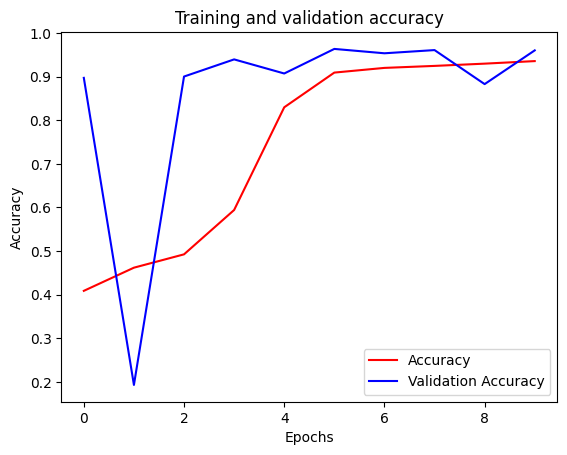

<Figure size 640x480 with 0 Axes>

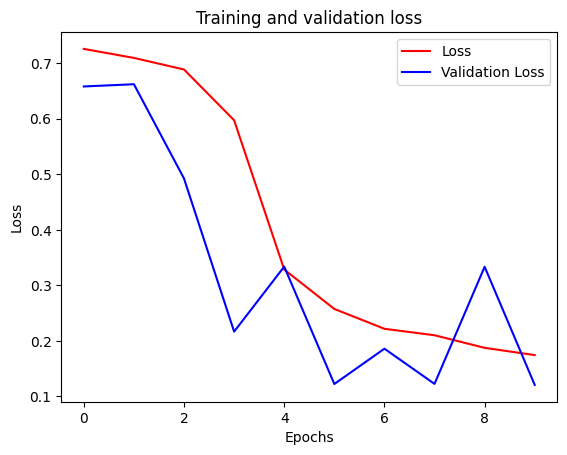

<Figure size 640x480 with 0 Axes>

In [139]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

In [146]:
from sklearn.metrics import precision_score, recall_score, f1_score


# Vos prédictions et vraies valeurs
y_pred = model.predict(test_padded_sequences)
y_true = y_test

print("Auc: %.2f%%" % (roc_auc(y_pred, y_true)))

# Arrondir les prédictions
y_pred = y_pred.round()


# Calcul de la précision
precision = precision_score(y_true, y_pred)

# Calcul du rappel
recall = recall_score(y_true, y_pred)

# Calcul du score F1
f1 = f1_score(y_true, y_pred)

print(f"Matrice de confusion : {confusion_matrix(y_test, y_pred)}")
print(f"Précision : {precision}")
print(f"Rappel : {recall}")
print(f"Score F1 : {f1}")


94/94 [==============================] - 5s 49ms/step
Auc: 0.98%
Matrice de confusion : [[2622   76]
 [  43  258]]
Précision : 0.7724550898203593
Rappel : 0.8571428571428571
Score F1 : 0.8125984251968504
